In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle"

In [ ]:
#!pip install kaggle

In [ ]:
#!kaggle datasets download -d "tawsifurrahman/covid19-radiography-database"

In [ ]:
#!kaggle config set -n path -v /content

In [ ]:
#!ls /content

In [ ]:
#!unzip /content/datasets/tawsifurrahman/covid19-radiography-database/covid19-radiography-database.zip

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32
img_height = 224 #180
img_width = 224 #180
IMAGE_SIZE = (img_height, img_width)

In [ ]:
labels = ['Normal', 'Covid']

In [ ]:
#!mkdir '/content/input'

In [ ]:
#!mv '/content/COVID-19_Radiography_Dataset/COVID/images' '/content/input'
# then rename 'images' folder to 'COVID' manually

In [ ]:
#!mv '/content/COVID-19_Radiography_Dataset/Normal/images' '/content/input'
# then rename 'images' folder to 'Normal' manually

In [ ]:
#!rm -rf '/content/input/.ipynb_checkpoints'

In [ ]:
#base_dir = '/content/input'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Train/",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 224 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Test/",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/gdrive/MyDrive/CMPE255/Final_Project/Val/",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 2 classes.


In [ ]:
#class_names = np.array(train_ds.class_names)
#print(class_names)

In [ ]:
class_names = ["Normal", "Covid"]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
numclasses=len(class_names)
def create_model():
    IMAGE_SIZE = (img_height, img_width)
    IMG_SHAPE = IMAGE_SIZE + (3,)
    pretrained_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    
    pretrained_model.trainable = False

    header = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(numclasses, activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
    ])

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = preprocess_input(inputs)
    x = pretrained_model(x, training=False)
    outputs = header(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 sequential_1 (Sequential)   (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import time
start_time = time.time()
EPOCHS=20
history = model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 17s 1s/step - loss: 0.7419 - accuracy: 0.5536 - val_loss: 0.6674 - val_accuracy: 0.5667
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.6736 - accuracy: 0.5982 - val_loss: 0.6132 - val_accuracy: 0.6500
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.6193 - accuracy: 0.6250 - val_loss: 0.5691 - val_accuracy: 0.6833
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 0.5812 - accuracy: 0.7143 - val_loss: 0.5319 - val_accuracy: 0.8167
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.5356 - accuracy: 0.7768 - val_loss: 0.4996 - val_accuracy: 0.8667
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 0.5063 - accuracy: 0.8036 - val_loss: 0.4707 - val_accuracy: 0.8833
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.4534 - accuracy: 0.8750 - val_loss: 0.4444 - val_accuracy: 0.9000
Epoch 8/20
7/7 [==============================] - 8

In [ ]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 227ms/step - loss: 0.3217 - accuracy: 0.9500


[0.32168418169021606, 0.949999988079071]

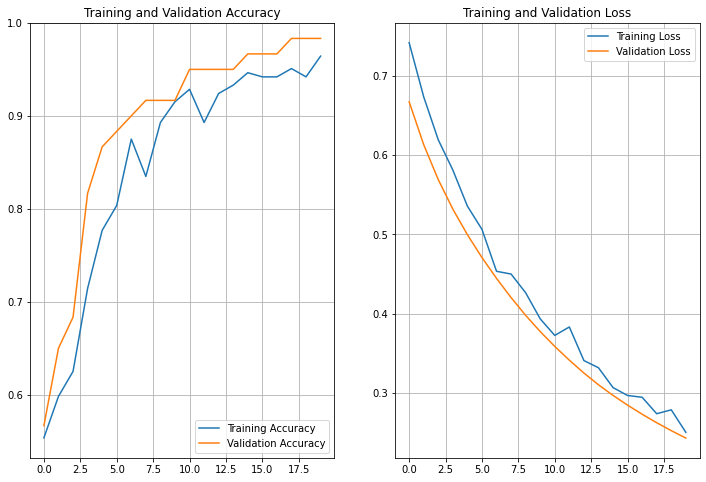

In [ ]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.show()
  fig.savefig('traininghistory.pdf')

plot_history(history, 'accuracy', 'val_accuracy')

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch

array([[0.84224   , 0.15776008],
       [0.13873497, 0.86126506],
       [0.19734113, 0.80265886],
       [0.69793427, 0.30206576],
       [0.1164069 , 0.883593  ],
       [0.9189106 , 0.08108944],
       [0.87128097, 0.12871897],
       [0.815032  , 0.18496795],
       [0.21437022, 0.7856298 ],
       [0.10471265, 0.89528733],
       [0.15000498, 0.8499951 ],
       [0.23017392, 0.7698261 ],
       [0.08534849, 0.91465145],
       [0.21386202, 0.786138  ],
       [0.16315527, 0.83684474],
       [0.09731971, 0.9026803 ],
       [0.8163308 , 0.18366921],
       [0.7628962 , 0.2371038 ],
       [0.81211287, 0.18788716],
       [0.9134644 , 0.08653553],
       [0.11733703, 0.88266295],
       [0.8712132 , 0.12878674],
       [0.63998866, 0.3600113 ],
       [0.14532869, 0.85467136],
       [0.4428958 , 0.55710423],
       [0.42141664, 0.57858336],
       [0.43487102, 0.5651289 ],
       [0.11670981, 0.88329023],
       [0.20358151, 0.7964185 ],
       [0.8604644 , 0.13953562],
       [0.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphamydxt5/assets
